# XAI Final Project — Driver Drowsiness Detection (DDD)

This notebook consolidates the full workflow:
1. Dataset loading & splits
2. Baseline model training (ResNet50)
3. XAI explanations (local, global, sanity checks)
4. Actionable XAI: Eye-ROI intervention (train + compare)
5. Explanations on the Eye-ROI model


## 0. Setup
We use PyTorch for training and explanation methods tailored to CNNs (occlusion, RISE, Grad-CAM, deletion tests).

In [1]:
# Core
import os, random, math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Torchvision
from torchvision import transforms, models

# Images
import cv2

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

plt.rcParams["figure.figsize"] = (10, 4)

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

## 1. Dataset loading and preparation
The DDD dataset is expected as:
- `driver_drowsiness_dataset/drowsy/`
- `driver_drowsiness_dataset/non_drowsy/`

Label mapping for the two classes:
- `drowsy -> 0`
- `non_drowsy -> 1`

In [ ]:
DATA_DIR = "driver_drowsiness_dataset" 

DROWSY_DIR = os.path.join(DATA_DIR, "drowsy")
NON_DROWSY_DIR = os.path.join(DATA_DIR, "non_drowsy")

# Get all image paths
drowsy_paths = [os.path.join(DROWSY_DIR, p) for p in os.listdir(DROWSY_DIR)]
non_drowsy_paths = [os.path.join(NON_DROWSY_DIR, p) for p in os.listdir(NON_DROWSY_DIR)]

# Combine and shuffle
all_paths = drowsy_paths + non_drowsy_paths
random.shuffle(all_paths)

total = len(all_paths)
# Split sizes
train_size = int(0.7 * total)
val_size   = int(0.2 * total)
test_size  = total - train_size - val_size

# Split the dataset
train_paths = all_paths[:train_size]
val_paths   = all_paths[train_size:train_size + val_size]
test_paths  = all_paths[train_size + val_size:]

# Shuffle each split
random.shuffle(train_paths)
random.shuffle(val_paths)
random.shuffle(test_paths)

print(f"Total: {len(all_paths)} | Train: {len(train_paths)} | Val: {len(val_paths)} | Test: {len(test_paths)}")


Total: 41793 | Train: 29255 | Val: 8358 | Test: 4180


In [ ]:
def extract_class_name(p: str) -> str:
    # Extracts the class name from the image path (folder in which it is located)
    return os.path.basename(os.path.dirname(p))

class DrowsinessDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get image and label
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        cls = extract_class_name(img_path)
        label = 0 if cls == "drowsy" else 1
        if self.transform:
            img = self.transform(img)
        return img, label


### Transforms & loaders
We use standard ImageNet normalization for ResNet50. Training includes light augmentation.

In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

BATCH_SIZE = 64

# Datasets
train_ds = DrowsinessDataset(train_paths, transform=train_tfms)
val_ds   = DrowsinessDataset(val_paths,   transform=eval_tfms)
test_ds  = DrowsinessDataset(test_paths,  transform=eval_tfms)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# Labels
IDX_DROWSY = 0
IDX_AWAKE  = 1


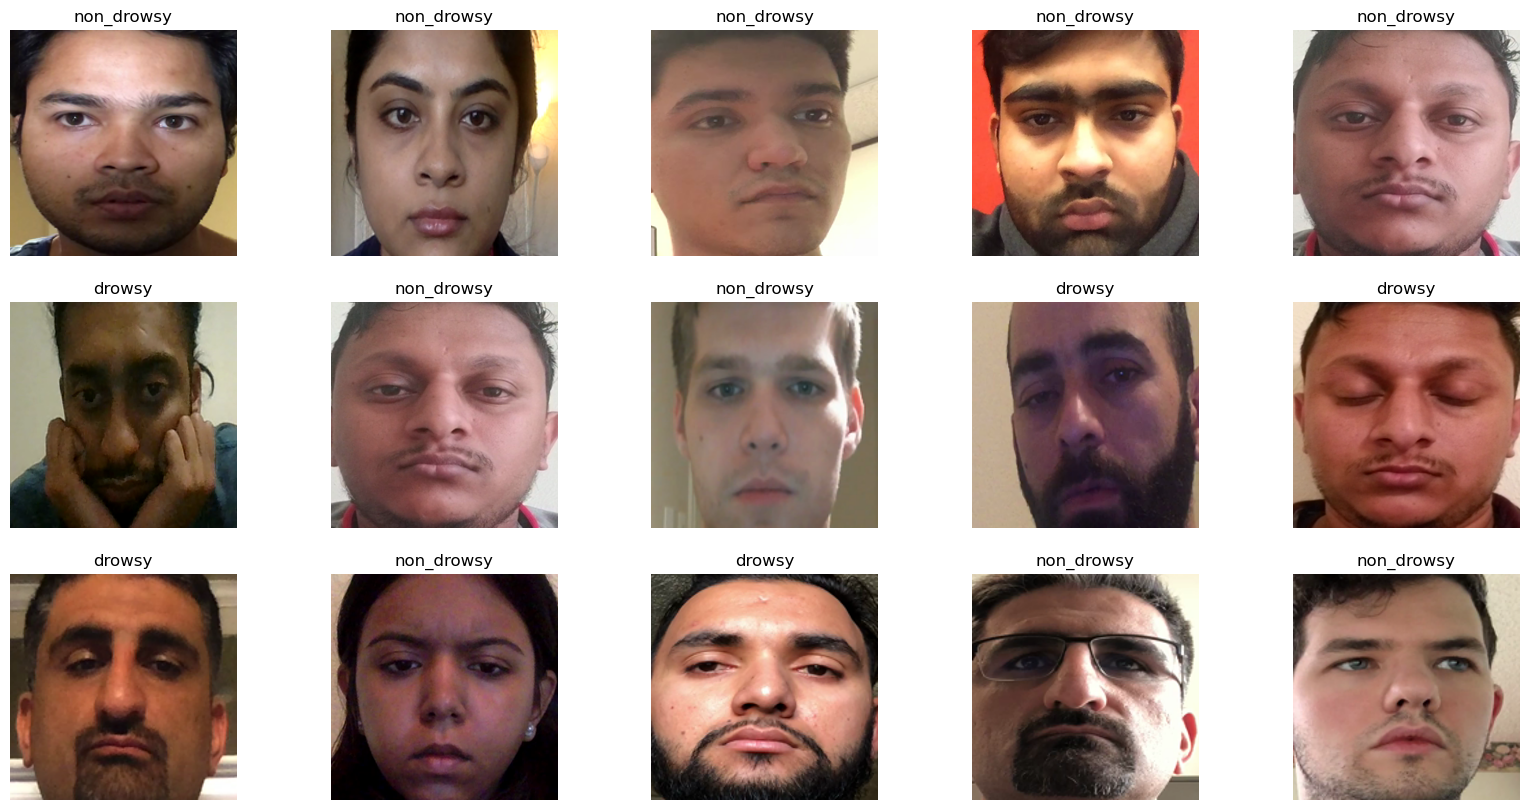

In [ ]:
# ImageNet statistics
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def tensor_to_rgb(img_t: torch.Tensor):
    # Converts a tensor image back to RGB format for visualization
    x = img_t.detach().cpu().numpy().transpose(1,2,0)
    x = (x * IMAGENET_STD + IMAGENET_MEAN)
    return np.clip(x, 0, 1)

def show_images_with_labels(paths, num_images=15):
    plt.figure(figsize=(20, 10))
    # Display first 15 images with labels
    for i, path in enumerate(paths[:num_images]):
        img = Image.open(path)
        label = extract_class_name(path)
        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

show_images_with_labels(train_paths, num_images=15)

## 2. Baseline model training (ResNet50)
We fine-tune the final fully-connected head for 2-class classification.
The best checkpoint is saved as `best_model.pth` (by validation loss).

In [ ]:
def build_resnet50_head(num_classes=2):
    model = models.resnet50(weights="IMAGENET1K_V2")
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last n layers
    n = 3
    child_counter = 0
    for child in model.children():
        child_counter += 1
        if child_counter > len(list(model.children())) - n:
            for param in child.parameters():
                param.requires_grad = True

    in_features = model.fc.in_features
    # Replace the final fully connected layer 
    model.fc = nn.Sequential(
        nn.Linear(in_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes),
    )

    model = model.to(device)
    
    return model

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    if is_train:
        model.train()

    total_loss = 0.0
    all_probs = []
    all_y = []

    # Iterate over batches
    for i, (xb, yb) in enumerate(loader):
        xb = xb.to(device)
        yb = yb.to(device)

        logits = model(xb)
        if isinstance(logits, tuple):
            logits = logits[0]
            
        # Loss criterion: cross entropy
        loss = F.cross_entropy(logits, yb)
        total_loss += float(loss.item())

        if is_train:
            # Backpropagation step if training
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        probs = F.softmax(logits, dim=1).detach().cpu().numpy()
        all_probs.append(probs)
        all_y.append(yb.detach().cpu().numpy())

    # Concatenate all predictions and labels
    all_probs = np.concatenate(all_probs, axis=0)
    all_y = np.concatenate(all_y, axis=0)
    avg_loss = total_loss / len(loader.dataset)

    # AUC needs both classes present
    try:
        auc = roc_auc_score((all_y == IDX_DROWSY).astype(int), all_probs[:, IDX_DROWSY])
    except Exception:
        auc = np.nan

    # Extract predictions and compute accuracy
    preds = np.argmax(all_probs, axis=1)
    acc = float((preds == all_y).mean())
    return avg_loss, acc, auc

def train_model(model, train_loader, val_loader, lr=1e-4, epochs=10, patience=3, ckpt_path="best_model.pth"):
    # Define optimizer (Adam)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = float("inf")
    counter = 0

    # Keep track of history
    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_auc":[], "val_auc":[]}

    for ep in range(1, epochs+1):
        # Train and validation epochs
        tr_loss, tr_acc, tr_auc = run_epoch(model, train_loader, optimizer=optimizer)
        va_loss, va_acc, va_auc = run_epoch(model, val_loader, optimizer=None)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        
        history["train_auc"].append(tr_auc)
        history["val_auc"].append(va_auc)

        print(f"Epoch {ep:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} auc {tr_auc:.3f} "
              f"| val loss {va_loss:.4f} acc {va_acc:.3f} auc {va_auc:.3f}")

        if va_loss < best_val:
            best_val = va_loss
            counter = 0
            # Save the model if best thus far
            torch.save(model.state_dict(), ckpt_path)
            print('Model saved')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping.")
                break

    return history

In [9]:
model = build_resnet50_head().to(device)
history = train_model(model, train_loader, val_loader, lr=1e-4, epochs=10, patience=3, ckpt_path="best_model.pth")

Epoch 01 | train loss 0.0008 acc 0.982 auc 0.999 | val loss 0.0000 acc 1.000 auc 1.000
Model saved
Epoch 02 | train loss 0.0000 acc 0.999 auc 1.000 | val loss 0.0000 acc 1.000 auc 1.000
Model saved
Epoch 03 | train loss 0.0000 acc 1.000 auc 1.000 | val loss 0.0000 acc 1.000 auc 1.000
Model saved
Epoch 04 | train loss 0.0000 acc 1.000 auc 1.000 | val loss 0.0000 acc 0.999 auc 1.000
Epoch 05 | train loss 0.0000 acc 1.000 auc 1.000 | val loss 0.0000 acc 1.000 auc 1.000
Epoch 06 | train loss 0.0000 acc 1.000 auc 1.000 | val loss 0.0001 acc 0.999 auc 1.000
Early stopping.


TEST | loss=0.0000 acc=1.000 auc=1.000
               precision    recall  f1-score   support

    drowsy(0)       1.00      1.00      1.00      2230
non_drowsy(1)       1.00      1.00      1.00      1950

     accuracy                           1.00      4180
    macro avg       1.00      1.00      1.00      4180
 weighted avg       1.00      1.00      1.00      4180



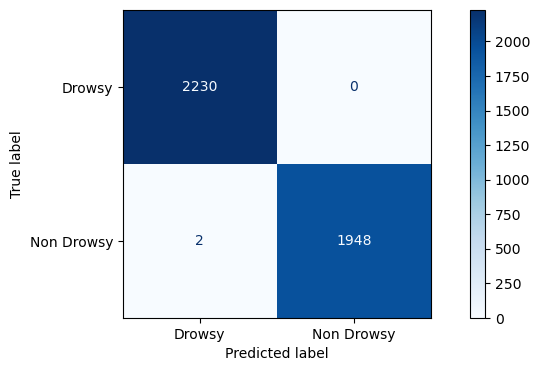

In [ ]:
# Load best checkpoint and evaluate on test
model = build_resnet50_head().to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

test_loss, test_acc, test_auc = run_epoch(model, test_loader, optimizer=None)
print(f"TEST | loss={test_loss:.4f} acc={test_acc:.3f} auc={test_auc:.3f}")

# Classification report
all_probs=[]
all_y=[]
for xb, yb in test_loader:
    with torch.no_grad():
        logits = model(xb.to(device))
        probs = F.softmax(logits, dim=1).cpu().numpy()
    all_probs.append(probs); all_y.append(yb.numpy())
all_probs = np.concatenate(all_probs, axis=0)
all_y = np.concatenate(all_y, axis=0)
preds = np.argmax(all_probs, axis=1)

print(classification_report(all_y, preds, target_names=["drowsy(0)","non_drowsy(1)"]))

# Display confusion matrix
cm = confusion_matrix(all_y, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Drowsy', 'Non Drowsy'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 3. XAI explanations (baseline model)
We implement:
- **Local**: Occlusion Sensitivity, RISE
- **Global**: Mean Grad-CAM (averaged over many samples)
- **Sanity checks**: Parameter randomization (Grad-CAM) + Deletion metric

In [ ]:
# Utilities for XAI
@torch.no_grad()
def predict_proba(model, img_t: torch.Tensor):
    # Predict class probabilities for a single image tensor
    logits = model(img_t.unsqueeze(0).to(device))
    probs = F.softmax(logits, dim=1)[0].detach().cpu().numpy()
    return probs

def show_sample(loader, target_label=None):
    # Show a sample from the loader, optionally filtering by target label
    for xb, yb in loader:
        for i in range(xb.size(0)):
            if target_label is None or int(yb[i]) == int(target_label):
                return xb[i], int(yb[i])
    return None, None


True label = 0 P(drowsy) = 1.0


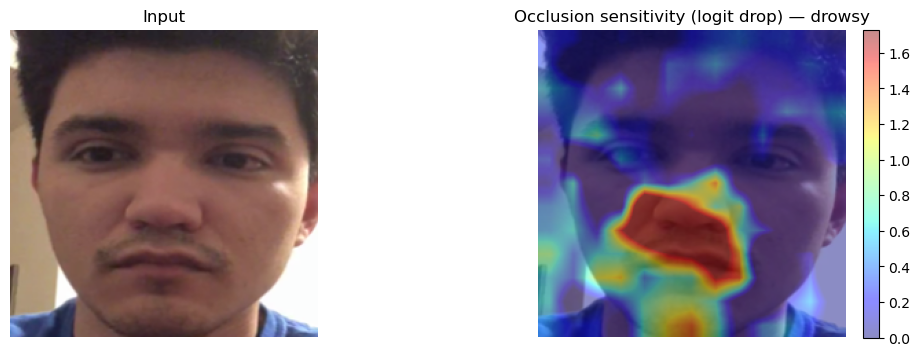

In [ ]:
# Local: Occlusion Sensitivity (logit-drop for better contrast)
def occlusion_sensitivity_logits(
    model,
    img_t: torch.Tensor,
    target_class: int,
    patch_size: int = 32,
    stride: int = 16,
    baseline_val: float = 0.0,  # 0 is ImageNet-mean in normalized space
):
    model.eval()
    H, W = img_t.shape[1], img_t.shape[2]
    with torch.no_grad():
        base_logit = float(model(img_t.unsqueeze(0).to(device))[0, target_class])

    # Output heatmap size
    out_h = 1 + (H - patch_size) // stride
    out_w = 1 + (W - patch_size) // stride
    heat = np.zeros((out_h, out_w), dtype=np.float32)

    # Slide the occlusion patch over the image
    for i, y in enumerate(range(0, H - patch_size + 1, stride)):
        for j, x in enumerate(range(0, W - patch_size + 1, stride)):
            occluded = img_t.clone()
            occluded[:, y:y+patch_size, x:x+patch_size] = baseline_val
            with torch.no_grad():
                # Compute logit for the occluded image
                logit = float(model(occluded.unsqueeze(0).to(device))[0, target_class])
            heat[i, j] = base_logit - logit

    heat_t = torch.tensor(heat)[None, None, ...]
    # Upsample to original image size
    heat_up = F.interpolate(heat_t, size=(H, W), mode="bilinear", align_corners=False)[0,0].numpy()
    return base_logit, heat_up

def plot_overlay(img_t, heat, title, cmap="jet", alpha=0.45):
    # Function to plot heatmap overlay on image
    rgb = tensor_to_rgb(img_t)
    vmax = np.percentile(heat, 95)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.imshow(rgb); plt.axis("off"); plt.title("Input")
    plt.subplot(1,2,2); plt.imshow(rgb); plt.imshow(heat, cmap=cmap, alpha=alpha, vmin=0.0, vmax=vmax); plt.axis("off"); plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

# img_t, y = show_sample(test_loader, target_label=IDX_DROWSY)
img_t, y = test_ds[21]
probs = predict_proba(model, img_t)
base_logit, occ = occlusion_sensitivity_logits(model, img_t, target_class=IDX_DROWSY)
print("True label =", y, "P(drowsy) =", probs[IDX_DROWSY])
plot_overlay(img_t, occ, "Occlusion sensitivity (logit drop) — drowsy")


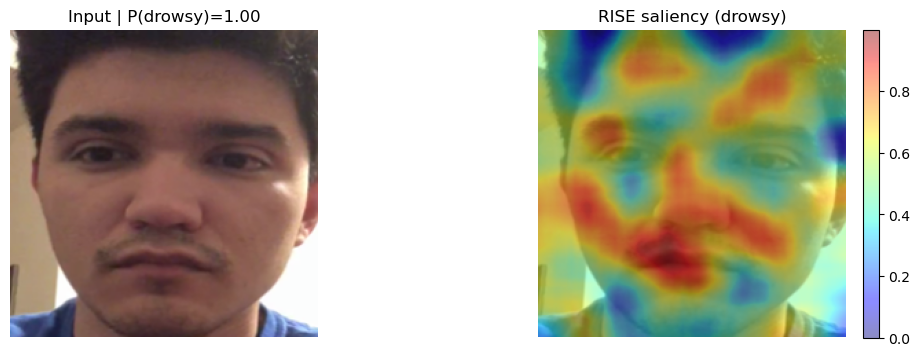

In [ ]:
# Local: RISE (Randomized Input Sampling for Explanation)
def generate_rise_masks(
    H, W,
    N=800,              # Number of random masks
    s=8,                # Grid size
    p1=0.5              # Probability of keeping a cell
):
    # Function to generate N random binary masks following RISE
    
    # Output mask size
    masks = np.empty((N, H, W), dtype=np.float32)
    # Calculate cell size
    cell_h = math.ceil(H / s)
    cell_w = math.ceil(W / s)
    # Upsampled size
    up_h = (s + 1) * cell_h
    up_w = (s + 1) * cell_w

    # Generate N masks
    for i in range(N):
        # Create random grid
        grid = (np.random.rand(s, s) < p1).astype(np.float32)

        # Bilinear upsample to (up_h, up_w)
        up = cv2.resize(grid, (up_w, up_h), interpolation=cv2.INTER_LINEAR)

        # Random shift then crop to (H, W)
        y0 = np.random.randint(0, cell_h)
        x0 = np.random.randint(0, cell_w)
        masks[i] = up[y0:y0+H, x0:x0+W]

    return masks


@torch.no_grad()
def rise_saliency(
    model,
    img_t: torch.Tensor,
    target_class: int,
    masks: np.ndarray,
    baseline_val: float = 0.0,
):
    # Function to compute RISE saliency map for a single image.
    
    model.eval()

    # Extract image dimensions
    C, H, W = img_t.shape
    # Number of masks
    N = masks.shape[0]

    img_t = img_t.to(device)
    scores = []

    # Apply each mask and get the score for the target class
    for i in range(N):
        # Create mask tensor
        mask = torch.tensor(masks[i], dtype=torch.float32)
        mask = mask.unsqueeze(0)  # 1 x H x W
        mask = mask.to(img_t.device)

        # Apply mask
        x_masked = img_t * mask + baseline_val * (1 - mask)
        # Get model prediction with masked image
        logits = model(x_masked.unsqueeze(0))
        prob = F.softmax(logits, dim=1)[0, target_class]
        scores.append(prob.item())

    scores = np.array(scores)
    # Compute saliency map as weighted sum of masks
    saliency = np.tensordot(scores, masks, axes=(0, 0))
    saliency = saliency / (scores.sum() + 1e-8)

    # Normalize
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    return saliency


# img_t, y = show_sample(test_loader, target_label=IDX_DROWSY)
img_t, y = test_ds[21]
probs = predict_proba(model, img_t)

H, W = img_t.shape[1], img_t.shape[2]
masks = generate_rise_masks(H, W, N=800, s=8, p1=0.5)
saliency_rise = rise_saliency(model, img_t, IDX_DROWSY, masks)

rgb = tensor_to_rgb(img_t)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(rgb)
plt.axis("off")
plt.title(f"Input | P(drowsy)={probs[IDX_DROWSY]:.2f}")

plt.subplot(1,2,2)
plt.imshow(rgb)
plt.imshow(saliency_rise, cmap="jet", alpha=0.45)
plt.axis("off")
plt.title("RISE saliency (drowsy)")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

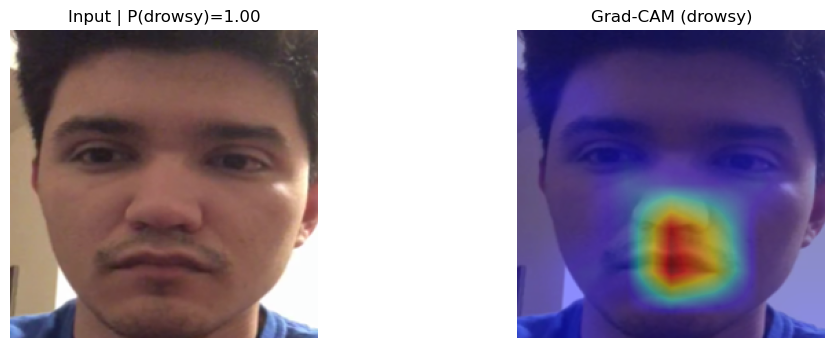

In [ ]:
# Local: Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register()

    def _register(self):
        # Register hooks to capture activations and gradients
        def fwd_hook(_, __, output):
            self.activations = output
        def bwd_hook(_, grad_input, grad_output):
            self.gradients = grad_output[0]
        self.target_layer.register_forward_hook(fwd_hook)
        self.target_layer.register_full_backward_hook(bwd_hook)

    def __call__(self, img_t: torch.Tensor, target_class: int):
        self.model.eval()
        self.model.zero_grad(set_to_none=True)

        x = img_t.unsqueeze(0).to(device)
        # Forward pass (obtain predictions)
        logits = self.model(x)
        score = logits[:, target_class].sum()
        score.backward()

        A = self.activations.detach()
        G = self.gradients.detach()
        # Compute weights from gradients
        w = G.mean(dim=(2,3), keepdim=True)
        # Compute Grad-CAM (weighted combination of activations)
        cam = (w * A).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        # Upsample to input image size
        cam = F.interpolate(cam, size=(img_t.shape[1], img_t.shape[2]), mode="bilinear", align_corners=False)
        cam = cam[0,0].detach().cpu().numpy()
        # Normalize
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

gcam = GradCAM(model, model.layer4[-1])

# img_t, y = show_sample(test_loader, target_label=IDX_DROWSY)
img_t, y = test_ds[21]
probs = predict_proba(model, img_t)
cam = gcam(img_t, target_class=IDX_DROWSY)

rgb = tensor_to_rgb(img_t)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(rgb); plt.axis("off"); plt.title(f"Input | P(drowsy)={probs[IDX_DROWSY]:.2f}")
plt.subplot(1,2,2); plt.imshow(rgb); plt.imshow(cam, alpha=0.45, cmap="jet"); plt.axis("off"); plt.title("Grad-CAM (drowsy)")
plt.show()


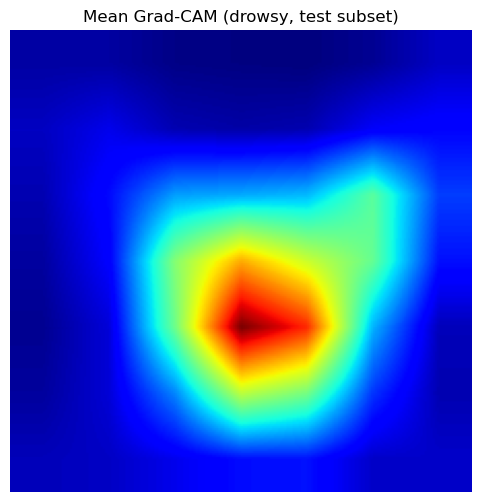

In [ ]:
# Global: Mean Grad-CAM over many drowsy samples
def indices_by_label(dataset: Dataset, label: int, max_n: int = 200):
    # Function to get indices of samples with a specific label
    idxs = []
    for i in range(len(dataset)):
        _, y = dataset[i]
        if int(y) == int(label):
            idxs.append(i)
            if len(idxs) >= max_n:
                break
    return idxs

def mean_gradcam(dataset: Dataset, idxs, target_class: int):
    cams = []
    # Compute Grad-CAM for each sample and accumulate
    for idx in idxs:
        img_t, _ = dataset[idx]
        # Compute Grad-CAM for the current sample
        cam = gcam(img_t, target_class=target_class)
        cams.append(cam)
    # Compute mean Grad-CAM
    m = np.mean(np.stack(cams, axis=0), axis=0)
    # Normalize
    m = (m - m.min()) / (m.max() - m.min() + 1e-8)
    return m

idxs = indices_by_label(test_ds, IDX_DROWSY, max_n=200)
mcam = mean_gradcam(test_ds, idxs, target_class=IDX_DROWSY)
plt.figure(figsize=(6,6))
plt.imshow(mcam, cmap="jet"); plt.axis("off"); plt.title("Mean Grad-CAM (drowsy, test subset)")
plt.show()


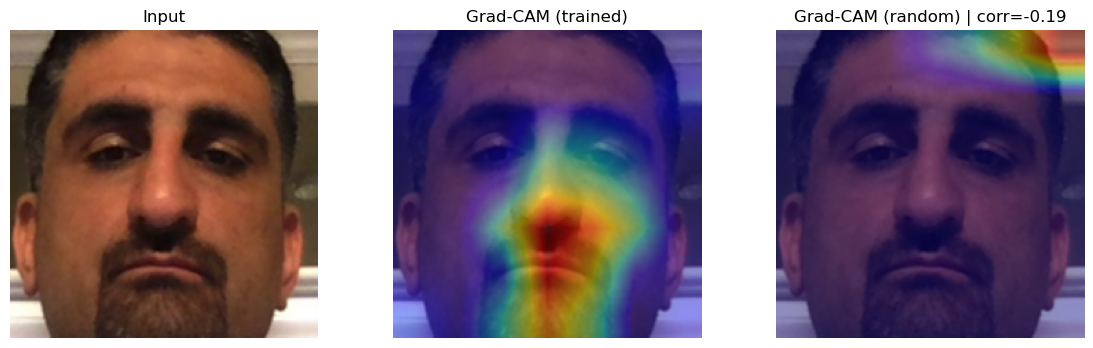

In [ ]:
# Sanity check 1: Randomize weights and recompute CAM
def randomize_weights_(m: nn.Module):
    if isinstance(m, nn.Conv2d):
        # Kaiming initialization for convolutional layers
        nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        # Xavier initialization for linear layers
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        # Initialize batch norm layers
        if m.weight is not None: nn.init.ones_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

def cam_corr(a, b):
    # Compute correlation between two CAMs
    a = a.reshape(-1) - a.mean()
    b = b.reshape(-1) - b.mean()
    return float(np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b) + 1e-8))

img_t, y = show_sample(test_loader, target_label=IDX_DROWSY)
# Compute Grad-CAM with trained weights
cam_trained = gcam(img_t, IDX_DROWSY)

model_rand = build_resnet50_head().to(device)
model_rand.apply(randomize_weights_)

# Compute Grad-CAM with randomized weights
gcam_rand = GradCAM(model_rand, model_rand.layer4[-1])
cam_random = gcam_rand(img_t, IDX_DROWSY)

# Compute correlation between the two CAMs
corr = cam_corr(cam_trained, cam_random)

rgb = tensor_to_rgb(img_t)
plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.imshow(rgb); plt.axis("off"); plt.title("Input")
plt.subplot(1,3,2); plt.imshow(rgb); plt.imshow(cam_trained, alpha=0.45, cmap="jet"); plt.axis("off"); plt.title("Grad-CAM (trained)")
plt.subplot(1,3,3); plt.imshow(rgb); plt.imshow(cam_random, alpha=0.45, cmap="jet"); plt.axis("off"); plt.title(f"Grad-CAM (random) | corr={corr:.2f}")
plt.show()


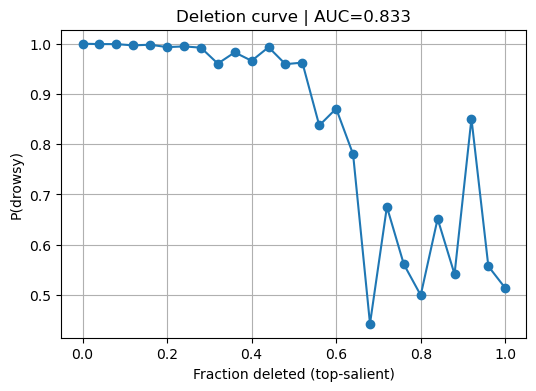

In [ ]:
# Sanity check 2: Deletion metric (remove top-salient pixels)
def deletion_curve(model, img_t, saliency_map, target_class=IDX_DROWSY, steps=25, baseline_val=0.0):
    # Compute deletion curve and AUC for a given saliency map
    H, W = saliency_map.shape
    flat = saliency_map.reshape(-1)
    order = np.argsort(-flat)
    total = H * W

    # Initialize lists to store fractions and probabilities
    fracs = [0.0]
    probs = [predict_proba(model, img_t)[target_class]]

    # Iteratively delete top-salient pixels and record probabilities
    for s in range(1, steps+1):
        # Compute fraction of pixels to delete
        frac = s / steps
        # Number of pixels to delete
        k = int(frac * total)
        # Create a copy of the image tensor
        x_del = img_t.clone().view(3, -1)
        idx = order[:k]
        # Set top-k salient pixels to baseline value
        x_del[:, idx] = baseline_val
        # Reshape back to original dimensions
        x_del = x_del.view(3, H, W)
        # Record fraction and predicted probability
        fracs.append(frac)
        probs.append(predict_proba(model, x_del)[target_class])

    # Compute AUC using trapezoidal rule (numpy function)
    auc = float(np.trapz(probs, fracs))
    return np.array(fracs), np.array(probs), auc

img_t, y = show_sample(test_loader, target_label=IDX_DROWSY)
cam = gcam(img_t, IDX_DROWSY)
fr, pr, auc = deletion_curve(model, img_t, cam, target_class=IDX_DROWSY)

plt.figure(figsize=(6,4))
plt.plot(fr, pr, marker="o")
plt.xlabel("Fraction deleted (top-salient)")
plt.ylabel("P(drowsy)")
plt.title(f"Deletion curve | AUC={auc:.3f}")
plt.grid(True)
plt.show()


## 4. Actionable XAI — Eye-ROI intervention
Goal: use explanations to **reduce spurious reliance** on non-eye regions.

Intervention: constrain the input by keeping only eye region (and blurring the rest).

This often trades accuracy for better alignment with domain cues — and that trade-off is itself actionable.

In [ ]:
# Eye ROI (robust): eye detection in upper-face mask

# Load Haar Cascade for eye detection (pre-trained model included with OpenCV)
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

class EyeROIMaskerHaar:
    def __init__(self, mode="blur", blur_ksize=41, expand=0.40):
        self.mode = mode
        # Ensure blur kernel size is odd
        self.blur_ksize = blur_ksize if blur_ksize % 2 == 1 else blur_ksize + 1
        self.expand = expand

    def __call__(self, rgb_uint8):
        rgb_uint8 = np.ascontiguousarray(rgb_uint8)
        H, W, _ = rgb_uint8.shape

        # Convert to grayscale for eye detection
        gray = cv2.cvtColor(rgb_uint8, cv2.COLOR_RGB2GRAY)

        # Focus on upper 60% of the image for eye detection
        y_top, y_bot = 0, int(0.60 * H)
        roi_gray = gray[y_top:y_bot, :]
        roi_rgb  = rgb_uint8[y_top:y_bot, :]

        # Detect eyes using Haar Cascade
        eyes = eye_cascade.detectMultiScale(
            roi_gray,
            scaleFactor=1.1,
            minNeighbors=6,
            flags=cv2.CASCADE_SCALE_IMAGE,
            minSize=(int(0.08 * W), int(0.06 * H)),   # This avoids tiny false positives
            maxSize=(int(0.50 * W), int(0.35 * H)),   # This avoids huge boxes (often cheeks/nose)
        )

        # Convert boxes back to full-image coordinates
        boxes = []
        for (x, y, w, h) in eyes:
            y_full = y + y_top

            # Filter: must be in upper half and not too low
            if y_full > 0.55 * H:
                continue

            # Filter: aspect ratio somewhat eye-like
            ar = w / (h + 1e-6)
            if ar < 0.8 or ar > 4.5:
                continue

            boxes.append((x, y_full, w, h))

        if len(boxes) < 1:
            # Fallback: no masking (if no eyes detected, return original)
            return rgb_uint8

        # Keep up to 2 best boxes (largest area) and prefer left-right separation
        boxes = sorted(boxes, key=lambda b: b[2]*b[3], reverse=True)[:4]

        # Try to pick 2 boxes far apart horizontally (two eyes)
        if len(boxes) >= 2:
            best_pair = None
            best_dist = -1
            # Select the pair with the largest horizontal distance between centers
            for i in range(len(boxes)):
                for j in range(i+1, len(boxes)):
                    xi, yi, wi, hi = boxes[i]
                    xj, yj, wj, hj = boxes[j]
                    ci = xi + wi/2
                    cj = xj + wj/2
                    dist = abs(ci - cj)
                    if dist > best_dist:
                        best_dist = dist
                        best_pair = (boxes[i], boxes[j])
            boxes = list(best_pair)
        else:
            boxes = boxes[:1]

        # Create mask of regions to keep
        keep_mask = np.zeros((H, W), dtype=np.uint8)

        for (x, y, w, h) in boxes:
            # Expand the box by a fraction to include some surrounding context
            dx = int(self.expand * w)
            dy = int(self.expand * h)
            # Compute expanded box coordinates
            x1 = max(0, x - dx); y1 = max(0, y - dy)
            x2 = min(W-1, x + w + dx); y2 = min(H-1, y + h + dy)
            # Set the keep region in the mask
            keep_mask[y1:y2+1, x1:x2+1] = 255

        if self.mode == "black":
            # Black-out non-eye regions
            out = rgb_uint8.copy()
            out[keep_mask == 0] = 0
            return out

        # Blur non-eye regions
        blurred = cv2.GaussianBlur(rgb_uint8, (self.blur_ksize, self.blur_ksize), 0)
        out = blurred
        out[keep_mask == 255] = rgb_uint8[keep_mask == 255]
        return out


class EyeROIDataset(Dataset):
    # Dataset that applies eye ROI masking to images
    def __init__(self, image_paths, roi_masker, post_tfms):
        self.image_paths = image_paths
        self.roi_masker = roi_masker
        self.post_tfms = post_tfms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        cls = extract_class_name(img_path)
        y = 0 if cls == "drowsy" else 1

        img = Image.open(img_path).convert("RGB")
        img = np.array(img)  # RGB uint8
        img = self.roi_masker(img)
        img = Image.fromarray(img)
        img = self.post_tfms(img)
        return img, y


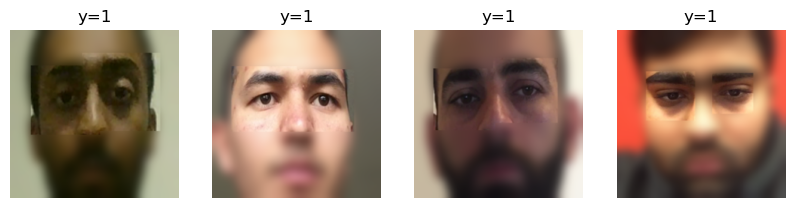

In [ ]:
# Build Eye-ROI loaders
roi_masker = EyeROIMaskerHaar(mode="blur", blur_ksize=41)

# Datasets and DataLoaders with Eye-ROI masking
train_ds_roi = EyeROIDataset(train_paths, roi_masker=roi_masker, post_tfms=train_tfms)
val_ds_roi   = EyeROIDataset(val_paths,   roi_masker=roi_masker, post_tfms=eval_tfms)
test_ds_roi  = EyeROIDataset(test_paths,  roi_masker=roi_masker, post_tfms=eval_tfms)

train_loader_roi = DataLoader(train_ds_roi, batch_size=BATCH_SIZE, shuffle=True)
val_loader_roi   = DataLoader(val_ds_roi,   batch_size=BATCH_SIZE, shuffle=False)
test_loader_roi  = DataLoader(test_ds_roi,  batch_size=BATCH_SIZE, shuffle=False)

# Visualize some Eye-ROI masked images
xb, yb = next(iter(train_loader_roi))
plt.figure(figsize=(10,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(tensor_to_rgb(xb[i]))
    plt.axis("off")
    plt.title(f"y={int(yb[i])}")
plt.show()


In [ ]:
# Train Eye-ROI model (same setup, new checkpoint)
model_roi = build_resnet50_head().to(device)
history_roi = train_model(model_roi, train_loader_roi, val_loader_roi, lr=1e-4, epochs=10, patience=3, ckpt_path="best_model_roi.pth")

# Load best Eye-ROI model and evaluate on test set
model_roi.load_state_dict(torch.load("best_model_roi.pth", map_location=device))
model_roi.eval()

# Evaluate on test set
roi_test_loss, roi_test_acc, roi_test_auc = run_epoch(model_roi, test_loader_roi, optimizer=None)
print(f"ROI TEST | loss={roi_test_loss:.4f} acc={roi_test_acc:.3f} auc={roi_test_auc:.3f}")


ROI TEST | loss=0.0110 acc=0.467 auc=0.466


### Before vs After summary
We compare baseline vs Eye-ROI on the corresponding test pipelines (full face vs ROI-masked inputs).

In [ ]:
print("Baseline  | loss={:.4f} acc={:.3f} auc={:.3f}".format(test_loss, test_acc, test_auc))
print("Eye-ROI   | loss={:.4f} acc={:.3f} auc={:.3f}".format(roi_test_loss, roi_test_acc, roi_test_auc))

Baseline  | loss=0.0000 acc=1.000 auc=1.000
Eye-ROI   | loss=0.0110 acc=0.467 auc=0.466


               precision    recall  f1-score   support

    drowsy(0)       0.00      0.00      0.00      2230
non_drowsy(1)       0.47      1.00      0.64      1950

     accuracy                           0.47      4180
    macro avg       0.23      0.50      0.32      4180
 weighted avg       0.22      0.47      0.30      4180



/opt/conda/envs/kernel_personalizado/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/kernel_personalizado/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/kernel_personalizado/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

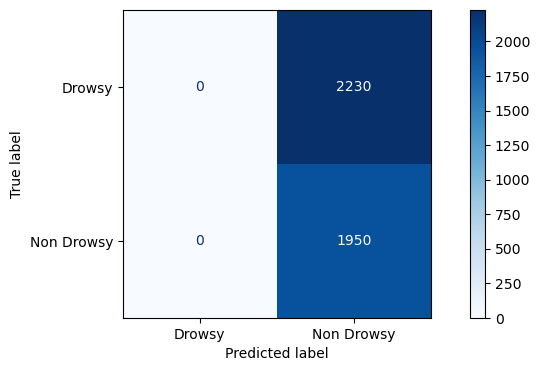

In [ ]:
# Classification report for Eye-ROI model
all_probs_roi=[]
all_y_roi=[]
for xb, yb in test_loader_roi:
    with torch.no_grad():
        logits = model_roi(xb.to(device))
        probs = F.softmax(logits, dim=1).cpu().numpy()
    all_probs_roi.append(probs)
    all_y_roi.append(yb.numpy())
all_probs_roi = np.concatenate(all_probs_roi, axis=0)
all_y_roi = np.concatenate(all_y_roi, axis=0)
preds_roi = np.argmax(all_probs_roi, axis=1)

print(classification_report(all_y_roi, preds_roi, target_names=["drowsy(0)","non_drowsy(1)"]))

# Confusion matrix for Eye-ROI model
cm_roi = confusion_matrix(all_y_roi, preds_roi)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_roi, display_labels=['Drowsy', 'Non Drowsy'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 5. XAI explanations (Eye-ROI model)
We apply Grad-CAM to several samples from the test set using the Eye-ROI trained model.
The goal is to check whether attention concentrates on eye-related regions more consistently.

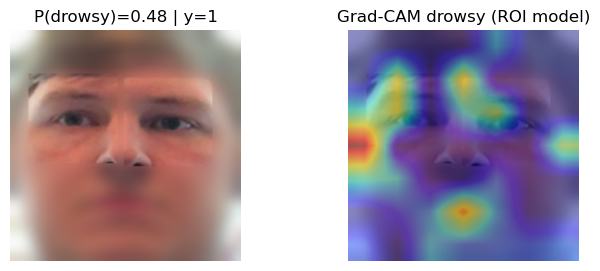

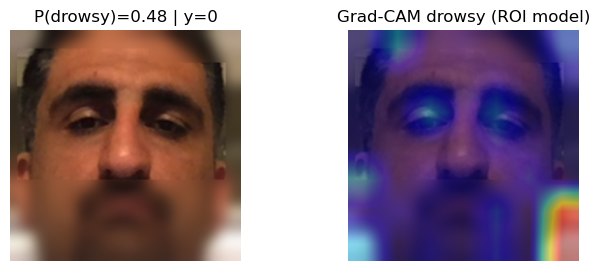

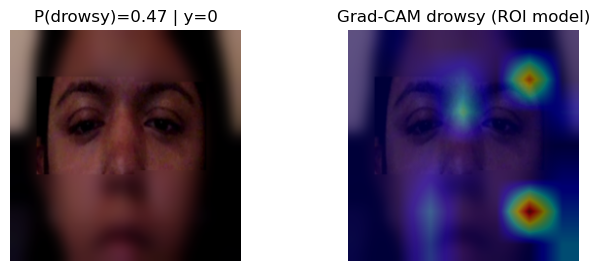

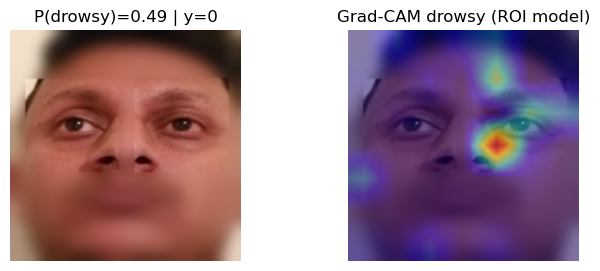

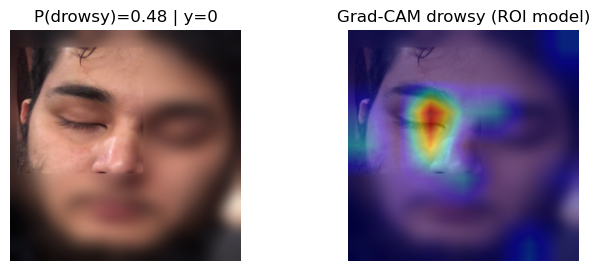

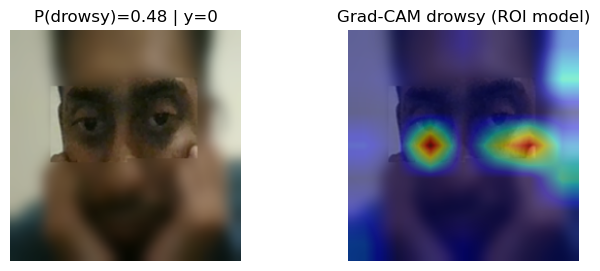

In [ ]:
# Rebuild Grad-CAM handle for ROI model
gcam_roi = GradCAM(model_roi, model_roi.layer4[-1])

# Show a few examples with Grad-CAM (drowsy)
def show_many_cams(model_, gcam_, loader_, n=6, target_class=IDX_DROWSY):
    shown = 0
    for xb, yb in loader_:
        for i in range(xb.size(0)):
            img_t = xb[i]
            # Get prediction and Grad-CAM
            probs = predict_proba(model_, img_t)
            cam = gcam_(img_t, target_class=target_class)
            rgb = tensor_to_rgb(img_t)

            plt.figure(figsize=(8,3))
            plt.subplot(1,2,1); plt.imshow(rgb); plt.axis("off")
            plt.title(f"P(drowsy)={probs[IDX_DROWSY]:.2f} | y={int(yb[i])}")
            plt.subplot(1,2,2); plt.imshow(rgb); plt.imshow(cam, alpha=0.45, cmap="jet"); plt.axis("off")
            plt.title("Grad-CAM drowsy (ROI model)")
            plt.show()

            shown += 1
            if shown >= n:
                return

show_many_cams(model_roi, gcam_roi, test_loader_roi, n=6, target_class=IDX_DROWSY)
